## Pip installing needed libraries 

In [1]:
%pip install nmrsim --quiet --exists-action i
%pip install optuna --quiet --exists-action i
%pip install comet_ml --quiet --exists-action i

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.6/499.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.2/532.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 25.4 MB/s eta 0:00:00


## Loading needed librareis 

In [2]:
# Import the necessary libraries for logging experiments with Comet.ml
# from comet_ml import Experiment

# Import core PyTorch functionality: PyTorch base, Neural Network module, and CUDA device support
import torch
import torch.nn as nn

# Import additional Python libraries for data manipulation, file I/O, and plotting
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.cuda.amp import autocast, GradScaler

# Import PyTorch classes for building a neural network model
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

# Import PyTorch optimizer classes for gradient-based optimization
from torch.optim import Adam, SGD, Adagrad, RMSprop, SparseAdam, LBFGS, Adadelta

# Import utility from scikit-learn for splitting data into train and validation sets
from sklearn.model_selection import train_test_split

# Import additional Python libraries for mathematical operations and plotting
import math
import matplotlib.pyplot
import time

# Import PyTorch Functional API for activation functions and other operations
import torch.nn.functional as F

# Import nmrsim library for NMR simulation
import nmrsim
from nmrsim import plt
from nmrsim import Multiplet

# Import random functions for generating random numbers
from random import randint, uniform

# Import itertools for generating Cartesian products of input iterables
from itertools import product

# Import Google Colab Drive library to access files stored in Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import Optuna library for hyperparameter optimization
import optuna

# Import PyTorch optim module for optimization algorithms
import torch.optim as optim

# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# For input & output files
import io

# Ipywidgets for interactive components
import ipywidgets as widgets
from ipywidgets import FileUpload
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

Mounted at /content/drive
Using cuda device


## Checking number of data files avaiable and Loading data 

In [3]:
#Checking how many files are in repository for training, testing, and validation
files = glob.glob('/content/drive/My Drive/Spectral_Data/test400/400MHz/spectral_data_*.csv')
print('Total number of files: ', len(files))

Total number of files:  38


## Model Training

In [7]:
class GHzData(Dataset):
    def __init__(self):
        # Load the list of CSV file paths.
        self.files = glob.glob(os.path.join('/content/drive/My Drive/Spectral_Data/test400/400MHz/spectral_data_*.csv'))

        self.y_60 = []  # List to store 60 MHz data.
        self.y_400 = []  # List to store 400 MHz data.

        # Loop through each file in the list of files.
        for self.file in self.files:
            # Read each file into a pandas DataFrame.
            self.df = pd.read_csv(self.file)

            # Extract 60 MHz and 400 MHz intensity columns and convert them to numpy arrays.
            self.array_60 = self.df['60MHz_intensity'].to_numpy()
            self.array_400 = self.df['400MHz_intensity'].to_numpy()

            # Append the arrays to the respective lists for 60 MHz and 400 MHz data.
            self.y_60.append(self.array_60)
            self.y_400.append(self.array_400)

        # Convert the 60 MHz list to a tensor, change dtype to float, and add a dimension (n, 1, 5500).
        self.tensor_60 = torch.Tensor(self.y_60).float().unsqueeze(1).to(device)

        # Convert the 400 MHz list to a tensor, change dtype to float, and add a dimension (n, 1, 5500).
        self.tensor_400 = torch.Tensor(self.y_400).float().unsqueeze(1).to(device)

        # Store the number of samples in the dataset.
        self.num_samples = len(self.y_60)

    def __getitem__(self, index):  # Method to retrieve an item from the dataset using an index.
        return self.tensor_60[index], self.tensor_400[index]

    def __len__(self):  # Method to return the total number of samples in the dataset.
        return self.num_samples


In [8]:
# Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_400,
                                                    test_size=0.1)

# Splits train data into validation data
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                      test_size=0.1)
# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)
valid_dataset = TensorDataset(valid_X, valid_y)

# Batch size change to higher batch sizes
train_dataloader = DataLoader(train_dataset, batch_size=192, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=192, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=192, shuffle=True)

<ipython-input-7-8b87a00ac718>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.tensor_60 = torch.Tensor(self.y_60).float().unsqueeze(1).to(device)


### CNN Module, fit(Training) and validation functions

In [4]:
class CNN(nn.Module):
    def __init__(self, num_layers, num_channels, kernel_size, drop_out):
        super().__init__()
        prev_dim = num_channels
        k = kernel_size
        layers = [nn.Conv1d(1, prev_dim, kernel_size=k, padding='same'), nn.ReLU(), nn.Dropout(p=drop_out)]

        for _ in range(1, num_layers):
            layers.append(nn.Conv1d(prev_dim, num_channels, kernel_size=k, padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=drop_out))

        layers.append(nn.Conv1d(prev_dim, 1, kernel_size=k, padding='same'))
        self.m = nn.Sequential(*layers)

    def forward(self, x):
        return self.m(x)


In [ ]:
def fit(model, dataloader, optimizer, criterion, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    scaler = GradScaler()

    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device).to(next(model.parameters()).dtype), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Normalize the loss
        loss = loss / accumulation_steps

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Update the model weights after accumulating gradients from 'accumulation_steps' mini-batches
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

    return running_loss / len(dataloader)


In [ ]:
def validate(model, dataloader, optimizer, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

### **Optimization of CNN structure**


In [ ]:
def objective_structure(trial):


    # Generate the model with hyperparameters
    num_layers = trial.suggest_int('num_layers', 3, 11, step=2)
    num_channels = trial.suggest_int('num_channels', 32, 128, step=32)
    kernel_size = trial.suggest_int('kernel_size', 3, 7, step=2)
    drop_out = trial.suggest_float("drop_out", 0.0, 0.5)

    model = CNN(num_layers, num_channels, kernel_size, drop_out).to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.00001)
    num_epoch = 30

    # Load Data
    # Establishing and loading data into notebook
    dataset = GHzData()

    #Splitting the data
    train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_400,
                                                        test_size=0.1)

    # Splits train data into validation data
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                          test_size=0.1)
    # Creating datasets
    train_dataset = TensorDataset(train_X, train_y)
    test_dataset = TensorDataset(test_X, test_y)
    valid_dataset = TensorDataset(valid_X, valid_y)

    # Batch size change to higher batch sizes
    train_dataloader = DataLoader(train_dataset, batch_size=192, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=192, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=192, shuffle=True)

    for epoch in range(num_epoch):
        # Training
        train_epoch_loss = fit(model, train_dataloader, optimizer, criterion)

        # Validation
        val_epoch_loss = validate(model, valid_dataloader, optimizer, criterion)

        trial.report(val_epoch_loss, epoch)

        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    print(f'Trial: {trial.number}, Final validation loss: {val_epoch_loss}')
    print(f'Parameters: {trial.params}')

    return val_epoch_loss



In [ ]:
# Optimize structure
study_structure = optuna.create_study(direction="minimize")
study_structure.optimize(objective_structure, n_trials=20)
best_params = study_structure.best_params


[I 2023-06-02 06:55:31,557] Trial 0 finished with value: 0.0019343493040651083 and parameters: {'num_layers': 3, 'num_channels': 32, 'kernel_size': 7, 'drop_out': 0.1606663768183056}. Best is trial 0 with value: 0.0019343493040651083.


Trial: 0, Final validation loss: 0.0019343493040651083
Parameters: {'num_layers': 3, 'num_channels': 32, 'kernel_size': 7, 'drop_out': 0.1606663768183056}


[I 2023-06-02 06:55:33,603] Trial 1 finished with value: 0.0008770536514930427 and parameters: {'num_layers': 5, 'num_channels': 64, 'kernel_size': 7, 'drop_out': 0.0100244833632388}. Best is trial 1 with value: 0.0008770536514930427.


Trial: 1, Final validation loss: 0.0008770536514930427
Parameters: {'num_layers': 5, 'num_channels': 64, 'kernel_size': 7, 'drop_out': 0.0100244833632388}


[I 2023-06-02 06:55:35,728] Trial 2 finished with value: 0.0018645043019205332 and parameters: {'num_layers': 3, 'num_channels': 96, 'kernel_size': 7, 'drop_out': 0.4092024080006767}. Best is trial 1 with value: 0.0008770536514930427.


Trial: 2, Final validation loss: 0.0018645043019205332
Parameters: {'num_layers': 3, 'num_channels': 96, 'kernel_size': 7, 'drop_out': 0.4092024080006767}


[I 2023-06-02 06:55:39,656] Trial 3 finished with value: 0.002893703291192651 and parameters: {'num_layers': 7, 'num_channels': 128, 'kernel_size': 3, 'drop_out': 0.22319400428824215}. Best is trial 1 with value: 0.0008770536514930427.


Trial: 3, Final validation loss: 0.002893703291192651
Parameters: {'num_layers': 7, 'num_channels': 128, 'kernel_size': 3, 'drop_out': 0.22319400428824215}


[I 2023-06-02 06:55:43,617] Trial 4 finished with value: 0.000890227616764605 and parameters: {'num_layers': 7, 'num_channels': 128, 'kernel_size': 3, 'drop_out': 0.25381498573140054}. Best is trial 1 with value: 0.0008770536514930427.


Trial: 4, Final validation loss: 0.000890227616764605
Parameters: {'num_layers': 7, 'num_channels': 128, 'kernel_size': 3, 'drop_out': 0.25381498573140054}


[I 2023-06-02 06:55:43,974] Trial 5 pruned. 
[I 2023-06-02 06:55:45,941] Trial 6 finished with value: 0.000980332843028009 and parameters: {'num_layers': 3, 'num_channels': 96, 'kernel_size': 7, 'drop_out': 0.46424743198907514}. Best is trial 1 with value: 0.0008770536514930427.


Trial: 6, Final validation loss: 0.000980332843028009
Parameters: {'num_layers': 3, 'num_channels': 96, 'kernel_size': 7, 'drop_out': 0.46424743198907514}


[I 2023-06-02 06:55:46,452] Trial 7 pruned. 
[I 2023-06-02 06:55:48,399] Trial 8 finished with value: 0.0010777146089822054 and parameters: {'num_layers': 5, 'num_channels': 64, 'kernel_size': 5, 'drop_out': 0.49772928588456417}. Best is trial 1 with value: 0.0008770536514930427.


Trial: 8, Final validation loss: 0.0010777146089822054
Parameters: {'num_layers': 5, 'num_channels': 64, 'kernel_size': 5, 'drop_out': 0.49772928588456417}


[I 2023-06-02 06:55:49,222] Trial 9 pruned. 
[I 2023-06-02 06:55:49,789] Trial 10 pruned. 
[I 2023-06-02 06:55:55,343] Trial 11 finished with value: 0.0008246480720117688 and parameters: {'num_layers': 7, 'num_channels': 128, 'kernel_size': 5, 'drop_out': 0.2910759790647156}. Best is trial 11 with value: 0.0008246480720117688.


Trial: 11, Final validation loss: 0.0008246480720117688
Parameters: {'num_layers': 7, 'num_channels': 128, 'kernel_size': 5, 'drop_out': 0.2910759790647156}


[I 2023-06-02 06:55:55,806] Trial 12 pruned. 
[I 2023-06-02 06:55:56,259] Trial 13 pruned. 
[I 2023-06-02 06:55:56,725] Trial 14 pruned. 
[I 2023-06-02 06:55:57,093] Trial 15 pruned. 
[I 2023-06-02 06:55:57,592] Trial 16 pruned. 
[I 2023-06-02 06:55:58,003] Trial 17 pruned. 
[I 2023-06-02 06:55:58,414] Trial 18 pruned. 
[I 2023-06-02 06:55:59,632] Trial 19 finished with value: 0.0009829157497733831 and parameters: {'num_layers': 7, 'num_channels': 32, 'kernel_size': 7, 'drop_out': 0.11612119697429439}. Best is trial 11 with value: 0.0008246480720117688.


Trial: 19, Final validation loss: 0.0009829157497733831
Parameters: {'num_layers': 7, 'num_channels': 32, 'kernel_size': 7, 'drop_out': 0.11612119697429439}


In [ ]:
best_params

{'num_layers': 7,
 'num_channels': 128,
 'kernel_size': 5,
 'drop_out': 0.2910759790647156}

### **Hyper-prarameter Optimization**


In [ ]:
def objective_hyperparameters(trial):

    # Generate the model with the best structure
    num_layers = int(best_params['num_layers'])
    num_channels = int(best_params['num_channels'])
    kernel_size = int(best_params['kernel_size'])
    drop_out = best_params['drop_out']
    num_epoch = 30
    model = CNN(num_layers, num_channels, kernel_size, drop_out).to(device)

   

    # Generate optimizers
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adadelta', 'Adagrad', 'RMSprop', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    batch_size = trial.suggest_int('batch_size', 64, 256, step=64)


    criterion = nn.MSELoss()

    # Load Data
    # Establishing and loading data into notebook
    dataset = GHzData()

    #Splitting the data
    train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_400,
                                                        test_size=0.1)

    # Splits train data into validation data
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                          test_size=0.1)
    # Creating datasets
    train_dataset = TensorDataset(train_X, train_y)
    test_dataset = TensorDataset(test_X, test_y)
    valid_dataset = TensorDataset(valid_X, valid_y)

    # Batch size change to higher batch sizes
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    # Training and validation loops
    for epoch in range(num_epoch):
        # Training
        train_epoch_loss = fit(model, train_dataloader, optimizer, criterion)

        # Validation
        val_epoch_loss = validate(model, valid_dataloader, optimizer, criterion)

        trial.report(val_epoch_loss, epoch)
        print(f'Trial: {trial.number}, Final validation loss: {val_epoch_loss}')
        print(f'Final validation loss: {val_epoch_loss}')

        # Handle pruning (same as before)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_epoch_loss
    


In [ ]:
# Optimize hyperparameters
study_hyperparameters = optuna.create_study(direction="minimize")
study_hyperparameters.optimize(objective_hyperparameters, n_trials=20)
best_hyperparams = study_hyperparameters.best_params


In [ ]:
best_hyperparams

**Training best model**

In [ ]:
# Create a new instance of the model using the best parameters
best_model = CNN(
    num_layers=best_params["num_layers"],
    num_channels=best_params["num_channels"],
    kernel_size=best_params["kernel_size"],
    drop_out=best_params["drop_out"]
)


# Create DataLoaders for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=best_hyperparams["batch_size"], shuffle=True)
validation_dataloader = DataLoader(valid_dataset, batch_size=best_hyperparams["batch_size"], shuffle=False)

# Train the model using the best parameters
criterion = torch.nn.MSELoss()
optimizer_name = best_hyperparams["optimizer"]
optimizer = getattr(torch.optim, optimizer_name)(best_model.parameters(), lr=best_hyperparams["lr"])

num_epochs = 30
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    train_loss = fit(best_model, train_dataloader, optimizer, criterion)
    validation_loss = validate(best_model, validation_dataloader, criterion)
    
    training_losses.append(train_loss)
    validation_losses.append(validation_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Validation Loss {validation_loss:.4f}")

# Plot the training and validation losses
matplotlib.pyplot.plot(training_losses, label="Training Loss")
matplotlib.pyplot.plot(validation_losses, label="Validation Loss")
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.title("Training and Validation Losses")
matplotlib.pyplot.show()


### Testing best model

In [ ]:
def test(model, test_dataloader, criterion):
    """
    Evaluate the performance of the model on the test dataset.
    
    Args:
        model (nn.Module): The trained model to evaluate.
        test_dataloader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function used for evaluation.
    
    Returns:
        test_loss (float): Mean loss of the model on the test dataset.
        accuracy (float): Accuracy of the model on the test dataset.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    loss_list_test = []

    # Disable gradient computation
    with torch.no_grad():
        # Loop over test dataset
        for inputs, labels in test_dataloader:
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(1)
            loss_list_test.append(loss)

            # Update label and prediction tensors
            _, labels = torch.min(labels, 1)
            _, predicts = torch.min(outputs.data, 1)
            predicts = predicts.unsqueeze(1)
            
            # Update total samples and correct predictions
            test_total += labels.size(0)
            test_correct += (predicts == labels).float().mean()

    # Calculate accuracy
    accuracy = (test_correct / test_total) * 100
    
    # Calculate mean loss
    test_loss /= len(test_dataloader.dataset)
    
    print(f' Mean Loss of Function: {test_loss}, Accuracy: {accuracy}')
    
    return test_loss, accuracy


## Model Prediction

In [5]:
def get_predictions(model, test_dataloader):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize a list to store the predictions
    predictions_list = []

    # Use torch.no_grad() context to disable gradient calculation, which speeds up the process
    with torch.no_grad():
        # Iterate over the test dataloader
        for inputs, _ in test_dataloader:
            # Get the model predictions for the given inputs
            predictions = model(inputs)
            
            # Convert the predictions tensor to a numpy array
            predictions_numpy = predictions.cpu().numpy()
            
            # Append the predictions numpy array to the list
            predictions_list.append(predictions_numpy)

    # Concatenate all predictions numpy arrays along the first axis
    predictions_concatenated = np.concatenate(predictions_list, axis=0)
    
    # Reshape the concatenated predictions to have 2 dimensions
    predictions_reshaped = predictions_concatenated.reshape(-1, predictions_concatenated.shape[-1])
    
    # Convert the reshaped predictions to a pandas DataFrame
    pred_df = pd.DataFrame(predictions_reshaped)

    # Return the predictions DataFrame
    return pred_df


In [11]:
# Get the predictions DataFrame for the given model and test dataloader
# model = CNN(
#     num_layers=best_params["num_layers"],
#     num_channels=best_params["num_channels"],
#     kernel_size=best_params["kernel_size"],
#     drop_out=best_params["drop_out"]
# ).to(device)

model = CNN(
    num_layers=5,
    num_channels=64,
    kernel_size=5,
    drop_out=0.2
).to(device)


predictions_df = get_predictions(model, test_dataloader)

### Using model to generate high resolution spectra

In [ ]:
def generate_high_res_plot(model, file_path, input_column_name,
                           input_ppm_column_name, output_ppm_column_name):
    """
    Generate a plot comparing original and high-resolution spectra
    from a given CSV file using a pre-trained model.

    Args:
        model: A pre-trained model for predicting high-resolution spectra.
        file_path: A string, path to the CSV file containing the data.
        input_column_name: A string, name of the column with the original spectra data.
        input_ppm_column_name: A string, name of the column with the original ppm values.
        output_ppm_column_name: A string, name of the column with the high-resolution ppm values.

    Returns:
        A matplotlib figure containing the comparison plot.
    """

    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Process the input data
    input_data = df[input_column_name].to_numpy()
    input_data = torch.Tensor(input_data).unsqueeze(0).unsqueeze(1).to(device)

    # Make predictions using the model
    predictions = model(input_data)
    predictions_numpy = predictions.detach().cpu().numpy().reshape(-1)

    # Plot the data
    fig, ax = matplotlib.pyplot.subplots()
    ax.plot(df[input_ppm_column_name], df[input_column_name], label='Original')
    ax.plot(df[output_ppm_column_name], predictions_numpy,
            label='High Resolution', linestyle='--')
    ax.legend()
    ax.set_xlabel('ppm')
    ax.set_ylabel('Intensity')
    ax.set_title('Comparison of Original and High Resolution Spectra')

    return fig


### Generating new Data

In [ ]:
# Change these variables to change resolutions of spectra generate
# Notation is typically: res_1=higher and res_2=lower (integer input)
res_1=400
res_2=60
# Function to generate NMR signals based on input argument of spectrometer freq
def NMR_Signal_Generator(spectrometer_frequencies):
    '''
    Takes input of list of 2 spectrometer frequencies in list format and
    generates a list of NMR signals using nmrsim library. An NMR signal given
    by this function is described by 1-4 (random), a 2Hz linewidth, a chemical
    shift from 0.5 to 9, a J coupling of 3 to 15Hz, a multiplicity of 0 to 5
    
    Parameters
    ----------
        spectrometer_frequencies: List
            List of 2 spectrometer frequencies
            
    Output
    -------
        signals_list: List
            List of NMR signals of the two resolutions
    
    
    '''
    # Assigning number of protons defined by peak integral
    integral = randint(1,4)
    #Assigning the linewidth of an NMR peak in the spectrum
    linewidth_hz = 2
    # Randomly return a floating point chemical shift assignment
    chemical_shift = uniform(0.5,9)
    # Randomly return a floating point coupling (J coupling) frequency
    coupling = uniform(3,15)
    # Randomly select a multiplicity (peak splitting)
    multiplicity = randint(0,5)
    # Generate a list of NMR signals using the Multiplet function of nmrsim
    signals_list = [(Multiplet(chemical_shift * frequency, integral, 
                               [(coupling,multiplicity)], linewidth_hz)) for 
                                frequency in spectrometer_frequencies]
    return signals_list
def create_random_spectra(num_peaks, res_1, res_2):
    '''
    Creates random NMR spectra given number of peaks desired, resolution 1
    and resolution 2
    
    Parameters
    -----------
        num_peaks: int
            Number of peaks in random spectrum
        res_1: int
            First desired resolution in MHz
        res_2: int
            Second desired resolution in MHz
    
    Output
    -------
        x_res_1: float
            Chemical shift in ppm of spectrum 1
        y_res_1: float
            Intensity of spectrum 1
        x_res_2: float
            Chemical shift in ppm of spectrum 2
        y_res_2: float
            Intensity of spectrum
    

    '''
    # Assigns desired NMR frequencies to a list
    spectrometer_frequencies = [res_1,res_2]
    # Creates blank dataframe with desired NMR frequencies column
    spectral_data = pd.DataFrame(columns=[f'{str(res_1)}MHz', f'{str(res_2)}MHz'])
    
    # Generates NMR Signals from NMRSIM using established list, generates
    # spectra and puts them in spectral_data frame
    for i in range(0,num_peaks):
        signals_list = NMR_Signal_Generator(spectrometer_frequencies)
        spectral_data.loc[len(spectral_data)] = signals_list

    # Defines spectrum object, from Multiplet class
    # Multiplets taken from spectral_data frequency df
    spectrum_res_1 = Multiplet(0,0.5,[],2) 
    for multiplet in spectral_data[f'{str(res_1)}MHz']:
        spectrum_res_1 += multiplet
        
    # Process repeated for other frequency
    spectrum_res_2 = Multiplet(0,0.5,[],2)
    for multiplet in spectral_data[f'{str(res_2)}MHz']:
        spectrum_res_2 += multiplet
    
    # Normalize the spectrometer frequencies and have n number of points on plots
    spectrum_res_1.vmin = -0.5 * spectrometer_frequencies[0]
    spectrum_res_1.vmax = 10.5 * spectrometer_frequencies[0]
    x_res_1, y_res_1 = spectrum_res_1.lineshape(points=5500)

    spectrum_res_2.vmin = -0.5 * spectrometer_frequencies[1]
    spectrum_res_2.vmax = 10.5 * spectrometer_frequencies[1]
    x_res_2, y_res_2 = spectrum_res_2.lineshape(points=5500)

    return x_res_1, y_res_1, x_res_2, y_res_2


def write_nmr_spectra(index, num_peaks, x_res_1, y_res_1, x_res_2, y_res_2, res_1, res_2):
    '''
    Writes generated NMR spectra to csv files
    
    Parameters
    -----------
        index: int
            Label as integer of NMR spectrum generated in a series
        num_peaks: int
            Specifies how many peaks are desired in spectrum
        x_res_1: float
            Output of write spectrum, chemical shift of spectrum 1
        x_res_2: float
            Output of write spectrum, chemical shift of spectrum 2
        y_res_1: float
            Output of write spectrum, intensity of spectrum 1
        y_res_2: float
            Output of write spectrum, intensity of spectrum 2
        res_1: int
            Resolution in MHz of spectrum 1
        res_2: int
            Resolution in MHz of spectrum 2
    
    Output
    -------
        filename: csv
            A csv containing the x, y data of spectra 1 and 2
    
    
    '''
    # Saving data to file
    sf = [res_1,res_2]
    x_ppm_res_1 = x_res_1/sf[0]
    x_ppm_res_2 = x_res_2/sf[1]
    spectral_data = pd.DataFrame(columns=[f'{str(res_1)}MHz_ppm',
                                        f'{str(res_1)}MHz_intensity', 
                                        f'{str(res_2)}MHz_ppm',
                                        f'{str(res_2)}MHz_intensity'])
    spectral_data[f'{str(res_1)}MHz_ppm'] = x_ppm_res_1
    spectral_data[f'{str(res_1)}MHz_intensity'] = y_res_1
    spectral_data[f'{str(res_2)}MHz_ppm'] = x_ppm_res_2
    spectral_data[f'{str(res_2)}MHz_intensity'] = y_res_2
    filename=f"/content/drive/My Drive/spectral_data/{str(res_1)}MHz/"+"spectral_data"+ "_"+str(num_peaks).zfill(2)+ "_" +str(index).zfill(5)+".csv"
    print(filename)
    spectral_data.to_csv(filename)

import time
# num_peaks = Number of Peaks that you want in your spectra
# j = how many spectra do you want.
x = time.time()

for j in range (0,5000):
    num_peaks = randint(5,16)
    #print(num_peaks)
    x_res_1, y_res_1, x_res_2, y_res_2 = create_random_spectra(num_peaks, res_1, res_2)
    write_nmr_spectra(j, num_peaks, x_res_1, y_res_1, x_res_2, y_res_2, res_1, res_2)

print(f'Time Elapsed: {round(time.time()-x, 5)} seconds') 

### User Part

#### Upload Files

In [12]:
print('Please upload your files.[One csv file]')
upload = FileUpload(accept='.csv', multiple=False)
display(upload)

Please upload your files.[One csv file]


FileUpload(value={}, accept='.csv', description='Upload')

In [13]:
# import codecs
uploaded_file = list(upload.value.values())[0]

In [14]:
# convert the memory view into a bytes and utf-8 decode it to a string
content = str(bytes(list(upload.value.values())[0]['content']), encoding='utf-8')

In [15]:
df = pd.read_csv(io.StringIO(content))

In [16]:
print('Check your uploaded file heads.')
df.head()

Check your uploaded file heads.


,Unnamed: 0,400MHz_ppm,400MHz_intensity,60MHz_ppm,60MHz_intensity
0,0,-0.500000,0.000009,-0.500000,0.000410
1,1,-0.498000,0.000009,-0.498000,0.000412
2,2,-0.495999,0.000009,-0.495999,0.000414
3,3,-0.493999,0.000009,-0.493999,0.000415
4,4,-0.491999,0.000009,-0.491999,0.000417


In [20]:
df1 = df

In [21]:
# Rename the first cokumn int "60MHz" for model training purpose
df1.rename(columns={df1.columns[0]: '60MHz'},inplace=True)

In [22]:
df1.head()

,60MHz,400MHz_ppm,400MHz_intensity,60MHz_ppm,60MHz_intensity
0,0,-0.500000,0.000009,-0.500000,0.000410
1,1,-0.498000,0.000009,-0.498000,0.000412
2,2,-0.495999,0.000009,-0.495999,0.000414
3,3,-0.493999,0.000009,-0.493999,0.000415
4,4,-0.491999,0.000009,-0.491999,0.000417


In [23]:
predictions_df = get_predictions(model, df)

ValueError: ignored

#### Save the output prediction

In [ ]:
predictions_df.to_csv('prediction_output.csv')

### Developer Part

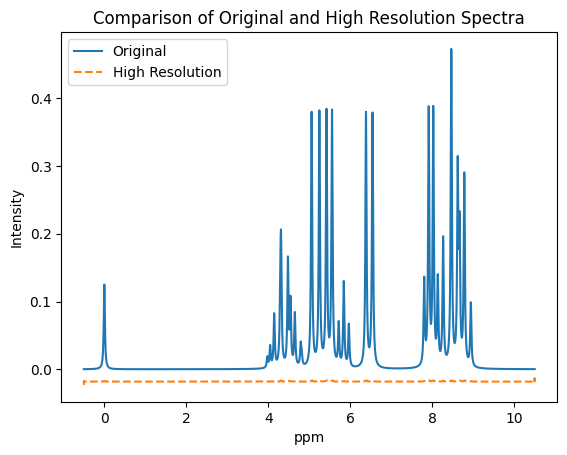

In [ ]:
file_path = '/content/drive/My Drive/spectral_data/test400/400MHz/spectral_data_09_00000.csv'
input_column_name = '60MHz_intensity'
input_ppm_column_name = '60MHz_ppm'
output_ppm_column_name = '400MHz_ppm'

fig = generate_high_res_plot(model, file_path, input_column_name, input_ppm_column_name, output_ppm_column_name)
matplotlib.pyplot.show()
